In [484]:
import torch
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets
import time
import random
import pandas as pd
import numpy as np

torch.backends.cudnn.deterministic = True

In [485]:
df = pd.read_excel('../input/ciao9cci/politica.xlsx', sheet_name="Foglio1")
pd.options.display.float_format = '{:,.0f}'.format
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

classes = [int(c) for c in df['cap_maj_master']]
documents = [d for d in df['testo']]
df = df[['cap_maj_master', 'testo']]
df.columns = ['classlabel', 'content']
df['classlabel'] = pd.factorize(df['classlabel'])[0]
df.classlabel = df.classlabel.astype(int)
df

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


,classlabel,content
0,0,: quali siano le determinazioni del Governo in...
1,0,: quali siano le valutazioni del Governo sugli...
2,0,- premesso che: la prospettata modifica degli ...
3,0,", premesso che: l'annuncio delle modifiche del..."
4,0,- premesso che -: nel disegno di legge collega...
...,...,...
5669,14,premesso che: da più parti si sollevano criti...
5670,14,premesso che: il florovivaismo in Italia vale...
5671,6,premesso che: il regolamento di Dublino III p...
5672,3,premesso che: in data 2 novembre 2017 il quot...


In [486]:
num_class=len(np.unique(df['classlabel'].values))
target_names=np.unique(df['classlabel'])

In [487]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 5000
LEARNING_RATE = 1e-3
BATCH_SIZE = 50
NUM_EPOCHS = 50
DROPOUT = 0.5
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
BIDIRECTIONAL = True
HIDDEN_DIM = 256
NUM_LAYERS = 2
OUTPUT_DIM = num_class

In [488]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    text=re.sub('\d+',' ',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text
import unicodedata
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return text
def tokenizer_porter(text):
    stop=set(stopwords.words('italian'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in filtered_sentence]

In [489]:
df['content']=df.content.apply(preprocessor).apply(strip_accents)
df.head(3)

,classlabel,content
0,0,quali siano le determinazioni del governo in ...
1,0,quali siano le valutazioni del governo sugli ...
2,0,premesso che la prospettata modifica degli sc...


In [490]:
df[['classlabel', 'content']].to_csv('./train_prepocessed.csv', index=None)

In [491]:
del df

In [492]:
TEXT = data.Field(sequential=True,
                  tokenize='spacy',
                  include_lengths=True) # necessary for packed_padded_sequence

LABEL = data.LabelField(dtype=torch.float)

In [493]:
fields = [('classlabel', LABEL), ('content', TEXT)]

dataset = data.TabularDataset(
    path="./train_prepocessed.csv", format='csv',
    skip_header=True, fields=fields)



In [494]:
TEXT.build_vocab(dataset,
                 max_size=VOCABULARY_SIZE,
                 vectors='fasttext.simple.300d',
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(dataset)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 5002
Number of classes: 21


In [495]:

import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, bidirectional, hidden_dim, num_layers, output_dim, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim,
                           num_layers=num_layers,
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim * num_layers, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    def forward(self, text, text_length):

        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.relu(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        return hidden

In [496]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(data_loader):
            text, text_lengths = batch_data.content
            logits = model(text, text_lengths)
            loss = criterion(logits, batch_data.classlabel.long())
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == batch_data.classlabel.long()).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [497]:
def predictTen(model, loader,min_len=4):
    model.eval()
    
    labels=[]
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(loader):
            text, text_lengths = batch_data.content
            preds = model(text, text_lengths)
            preds = torch.argmax(preds, 1)
            preds=preds.tolist()
            for x in preds:
                labels.append(x)
            
    return labels

In [498]:

def train(model, optimizer,criterion, train_dataloader, val_dataloader=None, epochs=10):
    """Train the LSTM model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    countdown=epochs
    count=1
    while countdown>0:
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0
        model.train()
        step=1
        for batch_idx, batch_data in enumerate(train_loader):
            text, text_lengths = batch_data.content
        
            ### FORWARD AND BACK PROP
            logits = model(text, text_lengths)
            loss = criterion(logits, batch_data.classlabel.long())
            total_loss += loss.item()
            optimizer.zero_grad()
            step=step+1
            loss.backward()
        
            ### UPDATE MODEL PARAMETERS
            optimizer.step()
        
        avg_train_loss = total_loss / len(train_dataloader)
        
        val_loss, val_accuracy = evaluate(model, val_dataloader,criterion)
        
        # Track the best accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'tut5-model.pt')
            countdown=epochs
        else:
            countdown=countdown-1
        time_elapsed = time.time() - t0_epoch
        print(f"{count :^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        count=count+1
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    return best_accuracy
    
        

In [499]:
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
labels = [example.classlabel for example in dataset]

In [500]:
from torch.utils.data.dataset import Subset
class TorchtextSubset(Subset):
    def __init__(self, dataset, indices):
        super(TorchtextSubset, self).__init__(dataset, indices)
        self.fields = self.dataset.fields
        self.sort_key = self.dataset.sort_key

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.873876   |  2.796751  |   13.45   |   17.03  
   2    |   2.824119   |  2.778799  |   14.00   |   16.80  
   3    |   2.800706   |  2.774369  |   14.91   |   16.91  
   4    |   2.768153   |  2.750299  |   14.91   |   16.86  
   5    |   2.727904   |  2.709248  |   16.36   |   16.95  
   6    |   2.649741   |  2.704998  |   16.36   |   17.08  
   7    |   2.596894   |  2.833578  |   20.00   |   16.86  
   8    |   2.513042   |  2.671781  |   22.36   |   16.78  
   9    |   2.425309   |  2.493554  |   26.00   |   16.98  
  10    |   2.374019   |  2.742758  |   20.55   |   16.73  
  11    |   2.546014   |  2.725827  |   16.73   |   16.68  
  12    |   2.394193   |  2.763661  |   22.00   |   16.96  
  13    |   2.197658   |  2.466041  |   30.73   |   16.90  
  14    |   2.123821   |  2.707080  |   26.18   |   16.84  
  15    |   2.038475

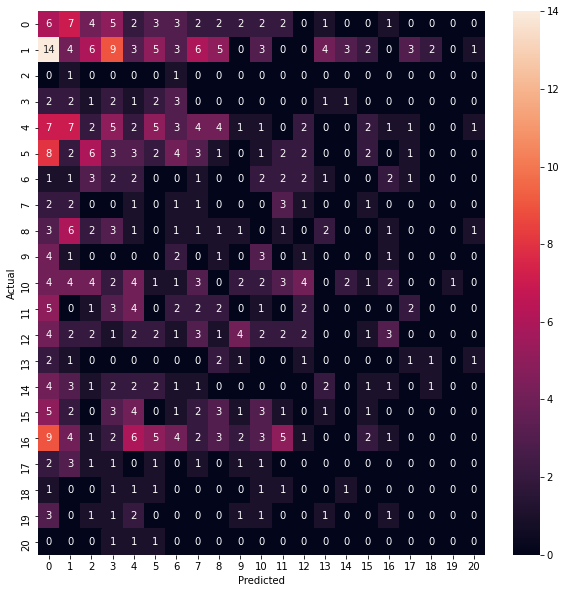


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.868650   |  2.807012  |   14.00   |   17.04  
   2    |   2.823186   |  2.777717  |   15.27   |   16.93  
   3    |   2.784067   |  2.753081  |   14.73   |   16.92  
   4    |   2.749278   |  2.765596  |   12.36   |   17.27  
   5    |   2.687561   |  2.785361  |   13.82   |   17.17  
   6    |   2.628586   |  2.704419  |   17.45   |   17.04  
   7    |   2.534457   |  2.643567  |   19.82   |   16.97  
   8    |   2.449907   |  2.640199  |   21.82   |   16.97  
   9    |   2.364577   |  2.529155  |   24.91   |   16.96  
  10    |   2.260028   |  2.512316  |   25.09   |   17.09  
  11    |   2.229455   |  2.502216  |   29.64   |   17.08  
  12    |   2.145480   |  2.699706  |   26.00   |   16.89  
  13    |   2.186822   |  2.557602  |   31.64   |   16.93  
  14    |   2.053971   |  2.446226  |   29.64   |   16.93  
  15    |   1.99030

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.10      0.19      0.13        42
           1       0.20      0.15      0.17        72
           2       0.04      0.67      0.07         3
           3       0.02      0.07      0.03        15
           4       0.06      0.04      0.05        48
           5       0.15      0.12      0.14        40
           6       0.08      0.20      0.11        20
           7       0.03      0.08      0.05        12
           8       0.08      0.08      0.08        24
           9       0.00      0.00      0.00        13
          10       0.05      0.03      0.03        40
          11       0.00      0.00      0.00        24
          12       0.00      0.00      0.00        32
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        21
          15       0.10      0.04      0.05        27
          16       0.12      0.02

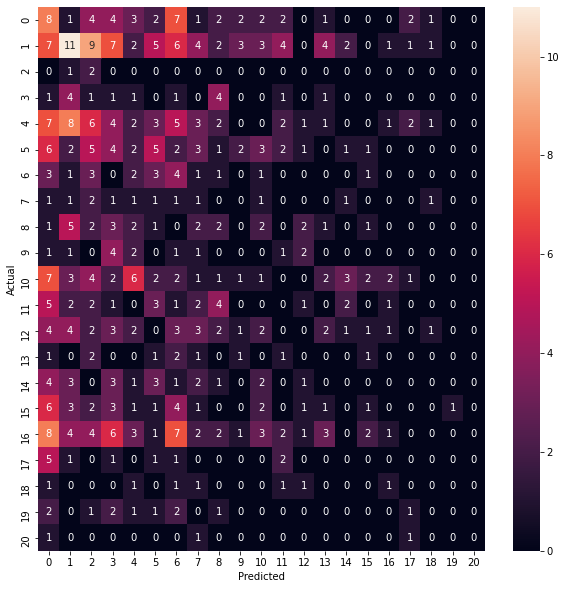


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.868062   |  2.798070  |   13.82   |   16.95  
   2    |   2.823691   |  2.777612  |   14.00   |   17.07  
   3    |   2.787738   |  2.747157  |   16.36   |   17.07  
   4    |   2.734386   |  2.721411  |   18.36   |   17.03  
   5    |   2.716714   |  2.719319  |   17.27   |   16.93  
   6    |   2.661267   |  3.251219  |   15.27   |   17.16  
   7    |   2.605767   |  2.639236  |   21.82   |   17.07  
   8    |   2.497305   |  2.559227  |   26.36   |   17.16  
   9    |   2.465374   |  2.528387  |   26.55   |   17.11  
  10    |   2.321622   |  2.563558  |   27.27   |   17.09  
  11    |   2.233584   |  2.474171  |   32.73   |   16.91  
  12    |   2.146692   |  2.523880  |   32.18   |   17.18  
  13    |   2.177279   |  2.421127  |   33.27   |   17.08  
  14    |   2.115086   |  2.365192  |   32.36   |   17.12  
  15    |   1.97798

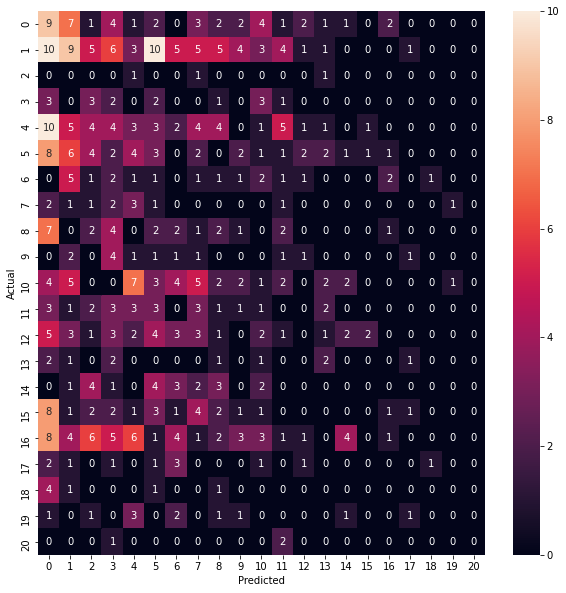


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.873803   |  2.805888  |   13.64   |   16.89  
   2    |   2.816388   |  2.788042  |   13.64   |   17.01  
   3    |   2.804638   |  2.804044  |   15.09   |   17.01  
   4    |   2.774059   |  2.777949  |   14.91   |   16.95  
   5    |   2.727087   |  2.731688  |   17.45   |   16.99  
   6    |   2.669001   |  2.708180  |   19.27   |   16.86  
   7    |   2.584693   |  2.659155  |   21.27   |   17.02  
   8    |   2.504211   |  2.674113  |   20.73   |   17.15  
   9    |   2.475864   |  2.703370  |   21.09   |   16.90  
  10    |   2.360285   |  2.680943  |   23.64   |   16.96  
  11    |   2.431968   |  2.715822  |   18.55   |   16.90  
  12    |   2.500388   |  2.590083  |   25.64   |   17.11  
  13    |   2.306616   |  2.578966  |   27.09   |   16.85  
  14    |   2.173768   |  2.484054  |   28.00   |   16.78  
  15    |   2.42556

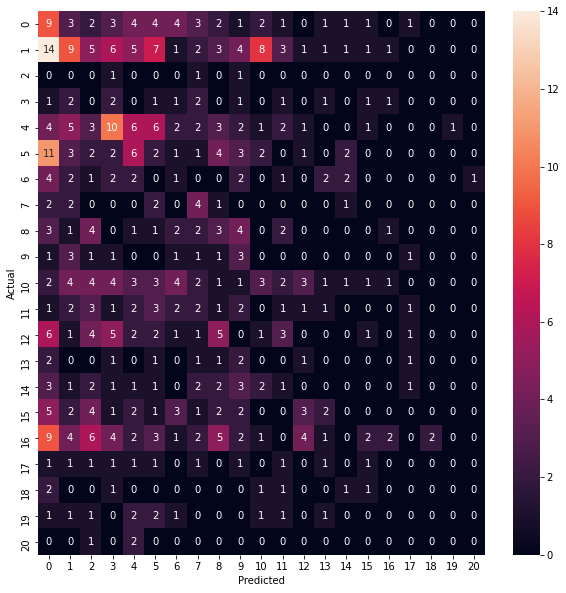


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.875067   |  2.802446  |   13.64   |   17.04  
   2    |   2.820374   |  2.807166  |   12.73   |   16.97  
   3    |   2.795922   |  2.784401  |   14.73   |   17.18  
   4    |   2.755959   |  2.709162  |   17.09   |   17.26  
   5    |   2.699873   |  2.694602  |   20.00   |   17.11  
   6    |   2.638119   |  2.619593  |   21.09   |   17.15  
   7    |   2.587136   |  2.630114  |   20.91   |   17.03  
   8    |   2.518584   |  2.559555  |   22.55   |   17.12  
   9    |   2.447024   |  2.883257  |   19.45   |   17.27  
  10    |   2.373645   |  2.545585  |   24.55   |   17.12  
  11    |   2.294027   |  2.477693  |   29.45   |   17.19  
  12    |   2.184012   |  2.407062  |   28.36   |   17.04  
  13    |   2.164304   |  2.597300  |   30.18   |   17.23  
  14    |   2.104425   |  2.665314  |   30.18   |   17.06  
  15    |   2.00869

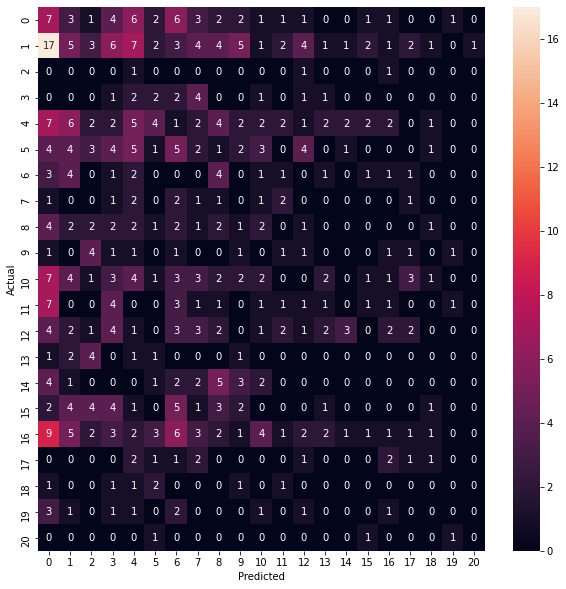


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.865877   |  2.802933  |   14.36   |   17.11  
   2    |   2.819705   |  2.793307  |   14.91   |   17.09  
   3    |   2.780010   |  2.814590  |   13.09   |   17.05  
   4    |   2.738181   |  2.694814  |   18.73   |   17.11  
   5    |   2.674830   |  2.717217  |   18.55   |   17.04  
   6    |   2.647517   |  2.762683  |   21.82   |   17.14  
   7    |   2.571185   |  2.607577  |   22.73   |   17.11  
   8    |   2.518504   |  2.943674  |   15.09   |   17.12  
   9    |   2.479408   |  2.554030  |   24.73   |   17.15  
  10    |   2.367116   |  2.522925  |   26.73   |   17.05  
  11    |   2.322316   |  2.502068  |   28.00   |   17.20  
  12    |   2.256288   |  2.543472  |   25.64   |   16.99  
  13    |   2.241605   |  2.507624  |   31.64   |   17.02  
  14    |   2.099175   |  2.543088  |   30.91   |   17.21  
  15    |   2.00792

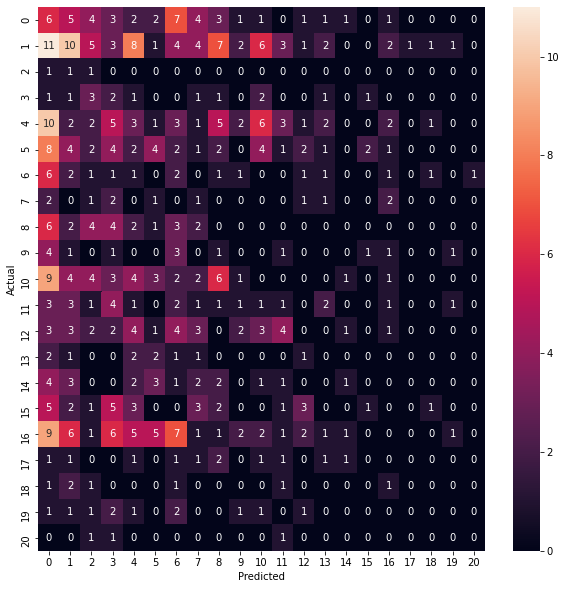


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.864553   |  2.803671  |   13.64   |   16.92  
   2    |   2.825472   |  2.784456  |   13.82   |   16.86  
   3    |   2.787135   |  2.756832  |   17.27   |   16.96  
   4    |   2.739464   |  2.702528  |   17.82   |   17.28  
   5    |   2.688288   |  2.680774  |   19.09   |   17.13  
   6    |   2.609706   |  2.632037  |   24.55   |   17.10  
   7    |   2.538499   |  2.629725  |   23.45   |   16.99  
   8    |   2.474937   |  2.556859  |   25.45   |   16.99  
   9    |   2.363198   |  2.540080  |   24.36   |   17.19  
  10    |   2.266265   |  2.499791  |   28.73   |   17.05  
  11    |   2.175211   |  2.367745  |   33.09   |   17.24  
  12    |   2.128342   |  2.305094  |   35.45   |   16.94  
  13    |   2.043700   |  2.361818  |   34.00   |   16.86  
  14    |   2.067146   |  2.551297  |   27.45   |   17.15  
  15    |   1.91650

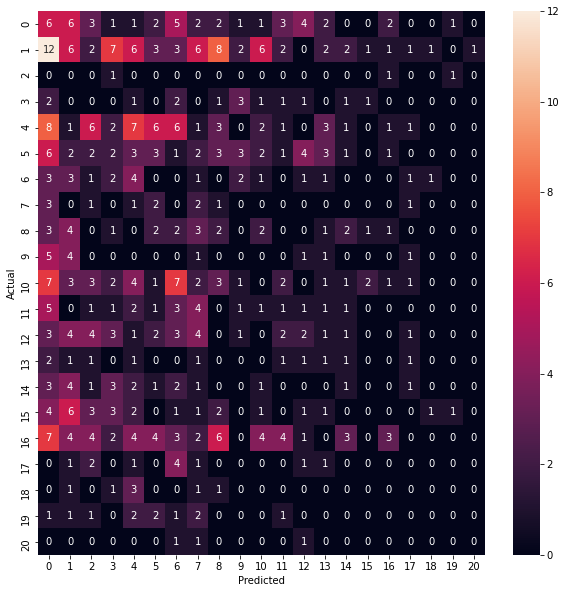


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.871316   |  2.809298  |   13.27   |   17.09  
   2    |   2.822633   |  2.793598  |   13.45   |   17.02  
   3    |   2.781123   |  2.815502  |   12.55   |   16.99  
   4    |   2.766677   |  2.733508  |   17.82   |   16.88  
   5    |   2.709561   |  2.872576  |   16.55   |   17.07  
   6    |   2.657727   |  2.746014  |   17.45   |   16.98  
   7    |   2.576427   |  2.735124  |   20.18   |   17.03  
   8    |   2.558993   |  2.576648  |   25.09   |   17.06  
   9    |   2.459989   |  2.540903  |   25.82   |   16.89  
  10    |   2.367650   |  2.554637  |   26.00   |   17.23  
  11    |   2.278135   |  2.424925  |   29.82   |   16.93  
  12    |   2.204277   |  2.472999  |   31.45   |   16.96  
  13    |   2.235919   |  2.518683  |   32.36   |   17.05  
  14    |   2.078730   |  2.400201  |   32.55   |   16.87  
  15    |   1.97608

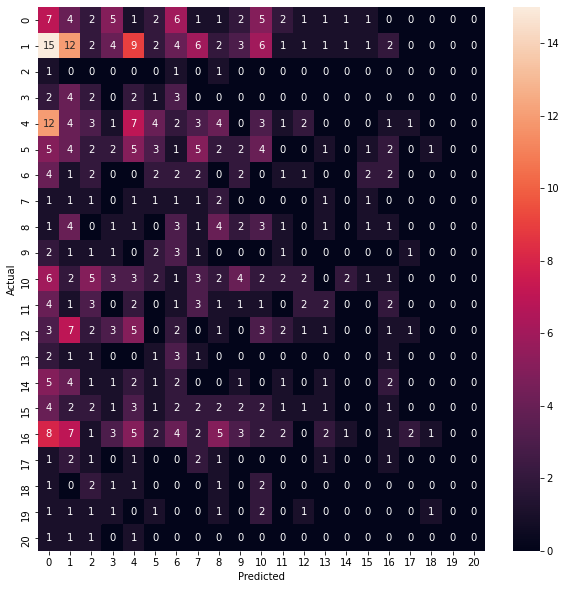


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.871895   |  2.793681  |   13.09   |   17.01  
   2    |   2.822303   |  2.776661  |   13.83   |   16.91  
   3    |   2.792953   |  2.823460  |   13.12   |   16.95  
   4    |   2.756826   |  2.702765  |   16.23   |   16.92  
   5    |   2.688464   |  2.664953  |   18.41   |   16.97  
   6    |   2.632507   |  2.605945  |   22.09   |   16.95  
   7    |   2.537906   |  2.560396  |   21.17   |   16.82  
   8    |   2.513885   |  2.479637  |   24.24   |   17.07  
   9    |   2.383773   |  2.547172  |   24.44   |   16.78  
  10    |   2.318410   |  2.451104  |   28.29   |   16.91  


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

idx_splits = list(skf.split(range(len(dataset)), y=labels))

accuracys = []
scores= []

for k, (train_idx, val_idx) in enumerate(idx_splits):
    
    #seed_torch(RANDOM_SEED)
    train_ds = TorchtextSubset(dataset, train_idx)
    val_ds = TorchtextSubset(dataset, val_idx)
    
    
    train_loader, val_loader = data.BucketIterator.splits(
        [train_ds, val_ds], 
        batch_sizes=[BATCH_SIZE,BATCH_SIZE], 
        device=DEVICE,
        sort_key=lambda x: len(x.content),
        sort_within_batch=True)

    INPUT_DIM = len(TEXT.vocab)

    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    torch.manual_seed(RANDOM_SEED)
    model = RNN(INPUT_DIM, EMBEDDING_DIM, BIDIRECTIONAL, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT, PAD_IDX)
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    criterion=criterion.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    accuracy=train(model, optimizer,criterion, train_loader, val_loader,10 )
    accuracys.append(accuracy)
    
    model.load_state_dict(torch.load('tut5-model.pt'))
    
    
    train_labels=[example.content for example in val_ds]
    val_labels = [example.classlabel for example in val_ds]
    
    y_pred=predictTen(model,val_loader)
    
    
    val_labels=list(map(int, val_labels))
    #print(list(zip(y_pred,val_labels)))
    score=precision_recall_fscore_support(y_true=val_labels, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(val_labels, y_pred, target_names=target_names))
    conf_mat = confusion_matrix(val_labels, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

    arr = np.array(scores)

print("Overall results of the cross-validation procedure")
print()

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(accuracys), np.std(accuracys)))
print('\nCV precision: %.3f +/- %.3f' % (np.mean(arr[:,0]), np.std(arr[:,0])))
print('\nCV recall: %.3f +/- %.3f' % (np.mean(arr[:,1]), np.std(arr[:,1])))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(arr[:,2]), np.std(arr[:,2])))
    
    
    